In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from pygit2 import Repository
import time
from dotenv import load_dotenv
import mlflow

load_dotenv()

True

# Определение директорий

In [2]:
test_mask_dir = "../data/processed/test/mask/"
test_img_dir = "../data/processed/test/img/"

train_dir = "../data/processed/train/"
val_dir = "../data/processed/validation/"
test_dir = "../data/processed/test/"

# Первый вариант генератора данных

## Генератор чтения масок

In [3]:
def MaskGenerator(directory, batch_size=1):
    i = 0
    files = sorted(os.listdir(directory))
    n_files = len(files)
    mask_batch = np.zeros([batch_size, 200, 2048, 1])
    while 1:
        for j in range(batch_size):
            
            mask = np.fromfile(os.path.join(directory,files[(i+j) % n_files]), dtype=np.ubyte)
            mask_batch[j, :, :, :] = mask.reshape([1, 200, 2048, 1])
            
        i += batch_size
        i = i % n_files
        
        yield mask_batch

## Совместный генератор чтения изображений и масок

Образцы данного генератора для тренировочных и валидационных данных с указанным размером батча подается на нейронную сеть при обучении.

In [4]:
def ImgMaskGenerator(directory, batch_size):

    mask_generator = MaskGenerator(directory=os.path.join(directory, 'mask'),
                                   batch_size=batch_size)
    
    img_datagen = ImageDataGenerator(rescale=1./255)
    
    img_generator = img_datagen.flow_from_directory(directory,
                                             class_mode=None,
                                             target_size=(200, 2048),
                                             batch_size=batch_size,
                                             shuffle=False,
                                             )
    
    train_generator = zip(img_generator, mask_generator)
    
    return train_generator

## Пример генератора

In [5]:
train_generator = ImgMaskGenerator(directory=train_dir,
                                   batch_size=64)

Found 27479 images belonging to 3 classes.


In [6]:
train_generator

## Проверка пары выходных данных генератора (изображение, маска)

Тип выходных данных генератора (д.б. tuple): <class 'tuple'>
(64, 200, 2048, 3)
(64, 200, 2048, 1)


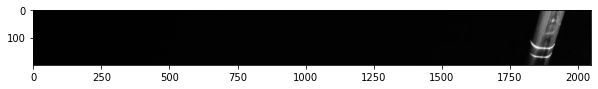

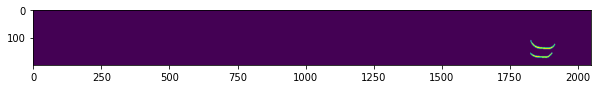

In [7]:
a = next(train_generator)

print('Тип выходных данных генератора (д.б. tuple):', type(a))
print(a[0].shape)
print(a[1].shape)

plt.figure(figsize=(10,10))
plt.imshow(a[0][0,:,:,:])

plt.figure(figsize=(10,10))
plt.imshow(a[1][0,:,:,:])

# Второй вариант генератора данных

## Формирование массивов с путями к файлам

In [8]:
def data_list_dir(directory: str) ->list:
    """
    Create sorted list of files in directory
    :param directory: input directory
    :return: list_dir
    """
    
    dir_list = sorted([os.path.join(directory, fname)
                       for fname in os.listdir(directory)])
    
    return dir_list

In [9]:
train_img_dir = os.path.join(train_dir, 'img')
images = data_list_dir(train_img_dir)

train_mask_dir = os.path.join(train_dir, 'mask')
masks = data_list_dir(train_mask_dir)

print("Number of samples:", len(images), len(masks))
for train_img_dir, train_mask_dir in zip(images[:10], masks[:10]):
    print(train_img_dir[-33:], "|", train_mask_dir[-34:])
    
print('Количество изображений:', len(images))

Number of samples: 27479 27479
210416D.003_1400701D.E003_0_0.jpg | 210416D.003_1400701D.E003_0_0.mask
210416D.003_1400701D.E003_0_1.jpg | 210416D.003_1400701D.E003_0_1.mask
6D.003_1400701D.E003_100000_1.jpg | 6D.003_1400701D.E003_100000_1.mask
6D.003_1400701D.E003_100005_1.jpg | 6D.003_1400701D.E003_100005_1.mask
16D.003_1400701D.E003_10000_1.jpg | 16D.003_1400701D.E003_10000_1.mask
6D.003_1400701D.E003_100010_1.jpg | 6D.003_1400701D.E003_100010_1.mask
6D.003_1400701D.E003_100015_1.jpg | 6D.003_1400701D.E003_100015_1.mask
6D.003_1400701D.E003_100020_1.jpg | 6D.003_1400701D.E003_100020_1.mask
6D.003_1400701D.E003_100025_1.jpg | 6D.003_1400701D.E003_100025_1.mask
6D.003_1400701D.E003_100030_1.jpg | 6D.003_1400701D.E003_100030_1.mask
Количество изображений: 27479


## Функции чтения изображения маски, выходные данные - TF тензор

In [10]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 1024
CHANNELS = 3


def read_data_img(file_path, height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    
    data = tf.io.read_file(file_path)
    data = tf.image.decode_png(data, channels=CHANNELS)
    data.set_shape([None, None, CHANNELS])
    data = tf.image.resize(images=data, size=[height, width])
    data = data / 255.
    
    return data

def read_data_mask(file_path, height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    
    data = tf.io.read_file(file_path)
    data = tf.io.decode_raw(data, tf.int8)
    data = tf.reshape(data, [200, 2048,1])
    data = tf.image.resize(images=data, size=[height, width])
    
    return data

## Совместный генератор чтения изображений и масок

In [11]:
def load_img_mask(image_list, mask_list):
    image = read_data_img(image_list)
    mask  = read_data_mask(mask_list)
    return image, mask


def img_mask_generator(directory, split='train', batch_size=1):
    
    image_list = data_list_dir(os.path.join(directory,'img'))
    mask_list = data_list_dir(os.path.join(directory,'mask'))
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(8*batch_size) if split == 'train' else dataset
    dataset = dataset.map(load_img_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

## Пример генератора

In [12]:
train_datagen = img_mask_generator(train_dir, batch_size=4)
val_datagen = img_mask_generator(val_dir, batch_size=4)

In [13]:
type(train_datagen)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

## Проверка пары выходных данных генератора (изображение, маска)

Тип выходных данных генератора (д.б. tuple): <class 'tuple'>
(4, 128, 1024, 3)
(4, 128, 1024, 1)


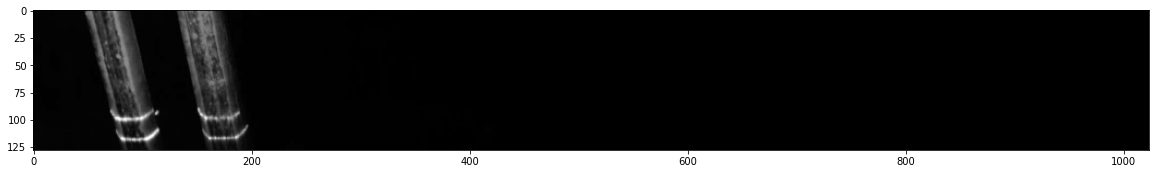

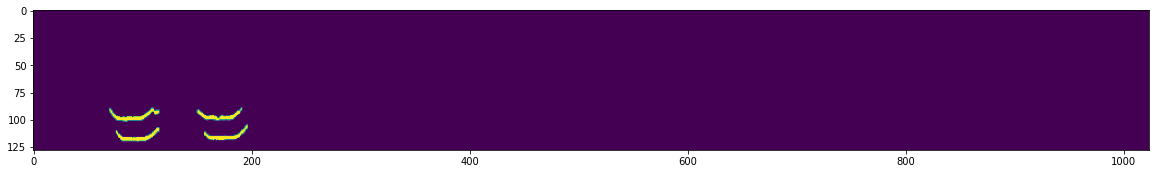

In [14]:
a = next(iter(val_datagen.take(5)))

print('Тип выходных данных генератора (д.б. tuple):', type(a))
print(a[0].shape)
print(a[1].shape)

plt.figure(figsize=(20,10))
plt.imshow(a[0][1,:,:,:])

plt.figure(figsize=(20,10))
plt.imshow(a[1][1,:,:,:])